In [61]:
from PIL import Image
%matplotlib inline
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

In [92]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [93]:
trans = transforms.Compose([transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                            ])

dataset = torchvision.datasets.ImageFolder(root = './drive/MyDrive/Colab Notebooks/image', transform = trans)
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

3929
2946
983
Dataset ImageFolder
    Number of datapoints: 3929
    Root location: ./drive/MyDrive/Colab Notebooks/image
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [94]:
trainloader = DataLoader(datasets['train'].dataset,
                         batch_size = 4,
                         shuffle = True,
                         num_workers = 4)

testloader = DataLoader(datasets['val'].dataset,
                         batch_size = 4,
                         shuffle = True,
                         num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [95]:
for X, y in testloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Shape of X [N, C, H, W]:  torch.Size([4, 3, 512, 512])
Shape of y:  torch.Size([4]) torch.int64


In [96]:
# 학습용 디바이스 정보 획득
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [97]:
# Neural Network를 정의하기 위해서 Class를 구현해봅니다.
# nn.Module 기억하세요 !

## ( input_size - filter_size ) / stride + 1 ---> activation map의 size

import torch.nn as nn
import torch.nn.functional as F

# nn.Module을 상속받는다. (내가 만들고 싶은 CNN 구조를 만들 수 있음)
class NeuralNetwork(nn.Module): 

    # input -> conv1 -> relu -> conv2 -> relu -> pool -> fc
    # 512x512x3 -> 254x254x10 -> 124x124x24 -> 62x62x24
    def __init__(self): # 생성자 call, 예를들면 from sklearn.porcessing import LabelEncoder -> encoder = LabelEncoder() 이런거랑 비슷, 기본적으로 self가 무조건 들어감
        super().__init__()        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10,kernel_size=6,stride=2)   
        self.relu = nn.ReLU()                                                 
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=24, kernel_size=6,stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                     # pooling 정의 # 크기 줄이기, 겹치지않게
        self.fc = nn.Linear(in_features=62*62*24, out_features=10)            # fc 정의 # 출력은 무조건 10

    # 위에 정의된 함수를 이제 순서대로 실행하게 만들자
    def forward(self,x): # x = input
        x = self.conv1(x) # 512x512x3 -> 254x254x10
        x = self.relu(x)
        x = self.conv2(x) # 254x254x10 -> 124x124x24
        x = self.relu(x)
        x = self.pool(x) # 124x124x24 -> 62x62x24
        x = torch.flatten(x,1) # 2차원 Matrix를 1차원 Vector로 만들어준다
        x = self.fc(x)
        return x
        # 한줄로 표현할수는 있다. 합성함수의 느낌만 보자 # return self.fc(torch.flatten(self.pool(self.relu(self.conv2(self.relu(self.conv1(x))))), 1))

In [98]:
# 모델 학습을 위한 디바이스 설정
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 10, kernel_size=(6, 6), stride=(2, 2))
  (relu): ReLU()
  (conv2): Conv2d(10, 24, kernel_size=(6, 6), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=92256, out_features=10, bias=True)
)


In [99]:
# 모델 학습 솔류션 수렴을 위한 최적화 모델 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [100]:
# 훈련 함수 정의
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [101]:
# 테스트 함수 정의
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [102]:
epochs = 5  # 학습을 원하는 만큼 수정요
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss: 2.216592  [    0/ 3929]
loss: 2.467873  [  400/ 3929]
loss: 1.872121  [  800/ 3929]
loss: 1.504567  [ 1200/ 3929]
loss: 2.141961  [ 1600/ 3929]
loss: 1.151852  [ 2000/ 3929]
loss: 2.398010  [ 2400/ 3929]
loss: 1.466069  [ 2800/ 3929]
loss: 1.931323  [ 3200/ 3929]
loss: 1.005584  [ 3600/ 3929]
Test Error: 
 Accuracy: 41.9%, Avg loss: 0.438817 

Epoch 2
-------------------------------
loss: 1.734278  [    0/ 3929]
loss: 1.502224  [  400/ 3929]
loss: 1.551182  [  800/ 3929]
loss: 1.150841  [ 1200/ 3929]
loss: 2.521162  [ 1600/ 3929]
loss: 1.880119  [ 2000/ 3929]
loss: 1.966272  [ 2400/ 3929]
loss: 1.409313  [ 2800/ 3929]
loss: 0.775407  [ 3200/ 3929]
loss: 1.202460  [ 3600/ 3929]
Test Error: 
 Accuracy: 47.8%, Avg loss: 0.372141 

Epoch 3
-------------------------------
loss: 1.206139  [    0/ 3929]
loss: 1.432258  [  400/ 3929]
loss: 1.366307  [  800/ 3929]
loss: 1.619917  [ 1200/ 3929]
loss: 0.550574  [ 1600/ 3929]
loss: 1.519519  [ 2000/ 3929]
loss: 0.907642  [ 2400/ 3929]
loss: 

In [103]:
classes = [
    'acc',
    'bag',
    'car',
    'eletronic',
    'jewelry',
    'm_wear',
    'shoes',
    'sports',
    'w_wear'
]

In [104]:
# 실제 사진을 넣는다 생각(실제 대입하는 사진 전처리하는 flow 필요)
for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
_, test = torch.max(pred,1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [105]:
# 실제값 예측값 비교
with torch.no_grad():
    pred = model(X)
    for i in range(len(pred)):
      predicted, actual = classes[test[i]], classes[y[i]]
      print('pred : ' ,predicted)
      print('actual : ',actual)

pred :  shoes
actual :  shoes


In [110]:
X

tensor([[[[ 1.2043,  1.1872,  1.1700,  ...,  0.1597,  0.1426,  0.1254],
          [ 1.2043,  1.1872,  1.1700,  ...,  0.1597,  0.1426,  0.1254],
          [ 1.1872,  1.1700,  1.1529,  ...,  0.1768,  0.1597,  0.1426],
          ...,
          [-0.2171, -0.2171, -0.1999,  ..., -0.7993, -0.7650, -0.7479],
          [-0.2342, -0.2342, -0.2171,  ..., -0.8335, -0.7993, -0.7822],
          [-0.2342, -0.2342, -0.2171,  ..., -0.8507, -0.8164, -0.7993]],

         [[ 1.4307,  1.4132,  1.3957,  ...,  0.3627,  0.3452,  0.3277],
          [ 1.4307,  1.4132,  1.3957,  ...,  0.3627,  0.3452,  0.3277],
          [ 1.4132,  1.3957,  1.3782,  ...,  0.3803,  0.3627,  0.3452],
          ...,
          [-0.0224, -0.0224, -0.0049,  ..., -0.7577, -0.7227, -0.7052],
          [-0.0399, -0.0399, -0.0224,  ..., -0.7927, -0.7577, -0.7402],
          [-0.0399, -0.0399, -0.0224,  ..., -0.8102, -0.7752, -0.7577]],

         [[ 1.8383,  1.8208,  1.8034,  ...,  0.6356,  0.6182,  0.6008],
          [ 1.8383,  1.8208,  

## 확인용 사진셋 불러오기

In [111]:
trans = transforms.Compose([transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                            ])

dataset = torchvision.datasets.ImageFolder(root = './drive/MyDrive/Colab Notebooks/test', transform = trans)
print(len(dataset))

6


In [119]:
batch_size = 4
dataloader = DataLoader(dataset,
                         batch_size = 4,
                         shuffle = False,
                         num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [120]:
# 학습용 디바이스 정보 획득
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [121]:
with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
        pred = model(X)
_, test = torch.max(pred,1)

for i in range(len(pred)):
  predicted = classes[test[i]]
  print('pred : ' ,predicted)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


pred :  m_wear
pred :  bag


In [122]:
test

tensor([5, 1], device='cuda:0')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f094d09f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
A

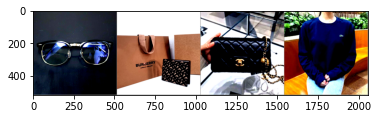

acc	 bag	 car	 eletronic	


In [125]:
# 많이 사용되는 코드니까 그냥 한번씩 쳐봅시다.
# 사용할 이미지를 batch_size 만큼 출력하는 코드.
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, labels = dataiter.next()  # batch size만큼의 이미지를 불러옵니다. e.g. 4

imshow(torchvision.utils.make_grid(images))
print(" ".join("%s\t" % classes[j] for j in range(batch_size)))